🏦 Credit Card Fraud Detection Dataset
Context

Detecting fraudulent credit card transactions is critical to protect customers and prevent financial losses. This dataset contains real transactions made by European cardholders in September 2013.

Dataset Overview

Total transactions: 284,807

Fraudulent transactions: 492 (~0.172% of all transactions)

Time span: 2 days

⚠️ Highly imbalanced dataset – most transactions are legitimate, making detection challenging.

Features

This dataset contains numerical features only, most of which are the result of a PCA transformation:

Feature	Description
V1, V2, … V28	Principal components from PCA (original features not provided due to confidentiality)
Time	Seconds elapsed between each transaction and the first transaction in the dataset
Amount	Transaction amount (useful for cost-sensitive learning)
Class	Response variable: 1 = fraud, 0 = legitimate
Challenges

Severe class imbalance: Fraudulent transactions make up less than 0.2% of the dataset.

Evaluation metric: Traditional accuracy is misleading. Use Area Under the Precision-Recall Curve (AUPRC) to measure model performance.

Tips for Analysis

Consider resampling techniques (SMOTE, undersampling) to address imbalance.

Explore feature scaling for 'Amount' and 'Time'.

Cost-sensitive learning can help prioritize catching fraud over minimizing false positives.

💡 Pro Tip: Because the dataset is extremely imbalanced, a model predicting “no fraud” for every transaction will achieve 99.8% accuracy — but this is useless for detecting actual fraud. Always check precision, recall, and the PR curve!

###**The data are converted from sets of input variables into a pca components**
### So here we get some random inputs that even they are not related to the datasets,. The main datasets inputs are encoded for security of the transactions


| Feature                        | Description                                                                                          |
|--------------------------------|------------------------------------------------------------------------------------------------------|
| Distance_From_Home              | Geographical distance between transaction location and cardholder's registered home address         |
| Distance_From_Last_Transaction  | Spatial proximity between current and previous transactions by the same cardholder                  |
| Ratio_To_Median_Purchase_Price  | Transaction amount relative to median purchase price, highlighting deviations from typical spending |
| Repeat_Retailer                 | Binary flag for transactions involving repeat retailers, influencing fraud detection                |
| Used_Chip                       | Binary flag indicating credit card EMV chip usage during transactions, impacting security          |
| Used_Pin_Number                 | Binary flag for cardholder-provided Personal Identification Number (PIN) usage, enhancing security |
| Online_Order                    | Binary flag for online transactions, relevant to fraud detection                                     |
| Fraud (Target Variable)         | Label indicating fraudulent (1) or legitimate (0) credit card transactions, essential for modeling |


In [2]:
#!/bin/bash
!curl -L -o ~/Downloads/creditcardfraud.zip\
  https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 65.9M    0  1177    0     0   4154      0  4:37:27 --:--:--  4:37:27  4154
curl: (23) Failure writing output to destination


In [3]:
!mkdir -p "/content/datasets"

!curl -L -o "/content/datasets/creditcardfraud.zip" \
  "https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud" && \
unzip -q "/content/datasets/creditcardfraud.zip" -d "/content/datasets/"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  96.7M      0 --:--:-- --:--:-- --:--:--  205M


In [4]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 4.9 MB/s eta 0:00:00


In [33]:
import h2o
import os
import pandas as pd
from h2o.automl import H2OAutoML

# --- Configuration and Initialization ---

# 1. Start the H2O Cluster (the JVM process)
try:
    print("Starting H2O cluster...")
    # Setting max_mem_size to 4G to give more resources for a larger dataset like creditcard.csv
    h2o.init(max_mem_size="4G")
except Exception as e:
    print(f"Error initializing H2O: {e}")
    h2o.cluster().shutdown()
    raise

# Define output path for the binary MOJO file
MOJO_DIR = "h2o_deployment_files"
MOJO_FILENAME = "binary_classification_leader.zip"
MOJO_PATH = os.path.join(MOJO_DIR, MOJO_FILENAME)

os.makedirs(MOJO_DIR, exist_ok=True)
print(f"MOJO file will be saved to: {MOJO_PATH}")


# --- Data Preparation ---

# Load data from the user-specified path
try:
    # Use H2O's import function for maximum efficiency
    h2o_frame = h2o.import_file(path="/content/datasets/creditcard.csv")
    print(f"Data loaded successfully from: /content/datasets/creditcard.csv")
except Exception as e:
    print(f"Error loading data: {e}. Please ensure the file exists at the specified path.")
    h2o.cluster().shutdown()
    raise

# Define predictor and response columns
y = 'Class' # The target variable for fraud detection
X = h2o_frame.col_names
X.remove(y)

# Convert the target column to factor (categorical) as required for classification in H2O
h2o_frame[y] = h2o_frame[y].asfactor()

# Split data into training and validation sets
train, valid = h2o_frame.split_frame(ratios=[0.8], seed=42)
print("\nData successfully loaded and split into H2O Frames.")


# --- AutoML Training ---

# 2. Run the AutoML process
# Increased runtime to 120 secs and enabled class balancing to handle imbalance
aml = H2OAutoML(
    max_runtime_secs=120,
    seed=42,
    sort_metric="AUC",
    project_name="Fraud_Detection_Deployment",
    balance_classes=True, # Critical for imbalanced datasets
    nfolds=0 # Set to 0 to speed up training in the sandbox environment
)

print("\nStarting H2O AutoML with Class Balancing... (Max 120 seconds)")
# The 'Class' column (y) is factor, which forces binary classification
aml.train(x=X, y=y, training_frame=train, validation_frame=valid)
print("\nAutoML process complete.")


# --- Model Export (MOJO) ---

# 3. Get the best performing model (Leader model)
leader_model = aml.leader
print(f"\nLeader Model ID: {leader_model.model_id}")

# 4. Download and save the model as a MOJO file
mojo_file_path = leader_model.download_mojo(
    path=MOJO_DIR,
    get_genmodel_jar=False
)

# Rename the downloaded MOJO file to our desired name
final_mojo_path = os.path.join(MOJO_DIR, MOJO_FILENAME)
os.rename(mojo_file_path, final_mojo_path)


print(f"\n--- SUCCESS ---")
print(f"The binary MOJO model file has been saved to: {final_mojo_path}")
print(f"The file size is: {os.path.getsize(final_mojo_path) / 1024:.2f} KB")


# --- Cleanup ---

# 5. Shut down the H2O cluster
h2o.cluster().shutdown()
print("\nH2O cluster shut down successfully.")

Starting H2O cluster...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdd8gwcgv
  JVM stdout: /tmp/tmpdd8gwcgv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdd8gwcgv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_gjx8m9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


MOJO file will be saved to: h2o_deployment_files/binary_classification_leader.zip
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Data loaded successfully from: /content/datasets/creditcard.csv

Data successfully loaded and split into H2O Frames.

Starting H2O AutoML with Class Balancing... (Max 120 seconds)
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

AutoML process complete.

Leader Model ID: GLM_1_AutoML_1_20251113_200941

--- SUCCESS ---
The binary MOJO model file has been saved to: h2o_deployment_files/binary_classification_leader.zip
The file size is: 96.15 KB
H2O session _sid_b502 closed.

H2O cluster shut down successfully.



Top 10 Feature Importances:
  variable  relative_importance  scaled_importance  percentage
0       V4             0.909264           1.000000    0.146285
1      V10             0.804440           0.884716    0.129420
2      V14             0.565532           0.621967    0.090984
3      V22             0.410342           0.451290    0.066017
4      V13             0.361648           0.397737    0.058183
5      V20             0.316388           0.347960    0.050901
6       V9             0.299258           0.329121    0.048145
7      V21             0.263558           0.289858    0.042402
8      V27             0.248606           0.273415    0.039996
9      V16             0.213607           0.234923    0.034366


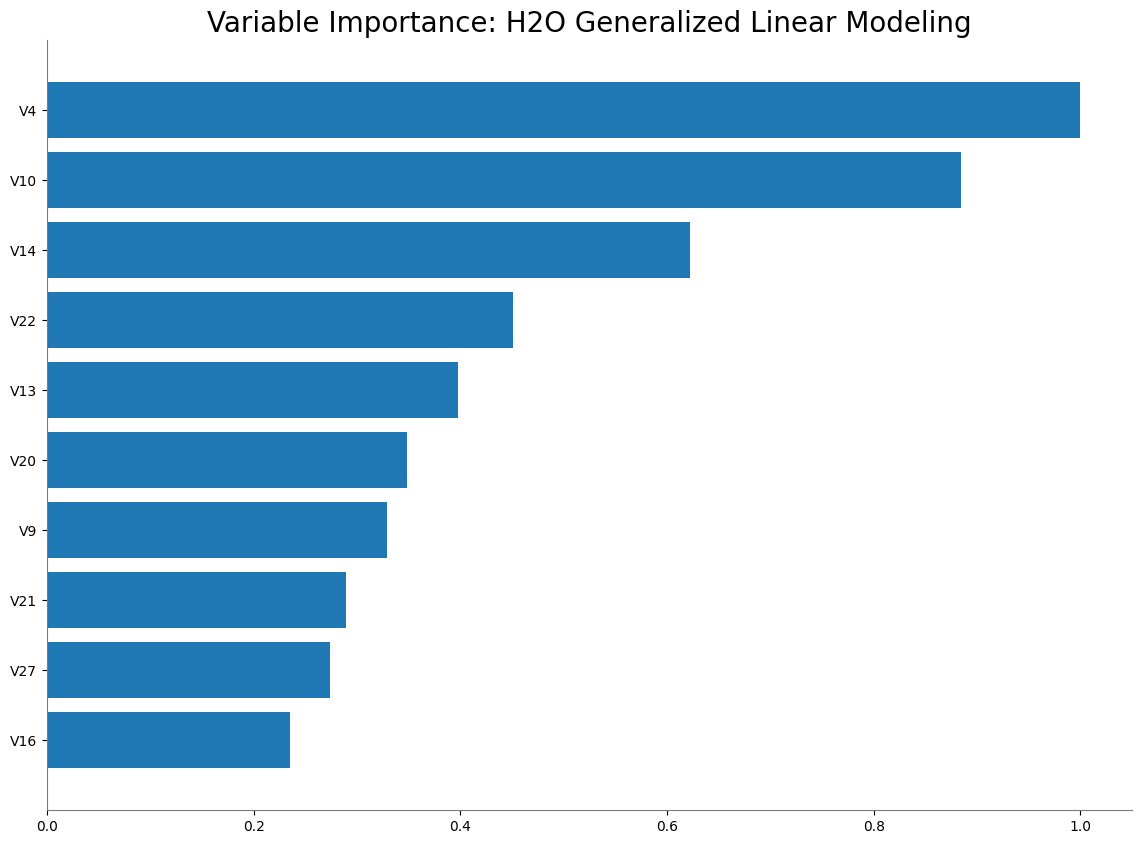

<Figure size 640x480 with 0 Axes>

In [34]:
# --- 1. Feature Importance ---
if hasattr(leader_model, "varimp") and leader_model.varimp() is not None:
    print("\nTop 10 Feature Importances:")
    varimp_df = leader_model.varimp(use_pandas=True)
    print(varimp_df.head(10))
else:
    print("\nLeader model does not provide variable importance (e.g., GLM without regularization).")

# Optional: Plot feature importance
try:
    leader_model.varimp_plot(num_of_features=10)
except:
    print("Unable to plot feature importance for this model type.")

## **This is how we can load the saved model:**

### **Since the data are converted to the PCA components, we will use the following approach to make the input:**

---

**If you had the original features, here’s the workflow:**

**1️⃣ Fit PCA on training data:**

```python
from sklearn.decomposition import PCA

# X_train = original features of training data
pca = PCA(n_components=28)
X_train_pca = pca.fit_transform(X_train)

# Train your model on X_train_pca
```

2️⃣ For a new transaction, transform it using the same PCA:
```python
# X_new = original features of new transaction
X_new_pca = pca.transform(X_new)
prediction = model.predict(X_new_pca)
```

✅ Key: You must use the same PCA object fitted on training data.

In [14]:
import h2o
from h2o.estimators import H2OGenericEstimator
import numpy as np
import pandas as pd
import time  # <-- for timing

# -------------------------------------------------------
# 1. Start H2O runtime
# -------------------------------------------------------
h2o.init(max_mem_size="2G", nthreads=-1)

# -------------------------------------------------------
# 2. Load MOJO model
# -------------------------------------------------------
mojo_path = "/content/h2o_deployment_files/binary_classification_leader.zip"
model = h2o.import_mojo(mojo_path)
print("✅ Model loaded successfully.\n")

# -------------------------------------------------------
# 3. Inspect model expected inputs
# -------------------------------------------------------
output_info = model._model_json["output"]
all_cols = output_info.get("names", [])

# Try multiple places to get the response column
response_col = (
    output_info.get("response_column_name") or
    output_info.get("response_column") or
    (all_cols[-1] if len(all_cols) > 0 else None)
)

input_cols = [c for c in all_cols if c != response_col]

print("📋 Input columns:", input_cols)
print("🎯 Response column:", response_col)

# -------------------------------------------------------
# 4. Auto-generate a sample input row
# -------------------------------------------------------
input_data = {}
data_info = output_info.get("data_info", [])

for info in data_info:
    col_name = info["name"]
    if col_name == response_col:
        continue
    col_type = info["type"]
    if col_type in ["enum", "string"]:
        input_data[col_name] = ["A"]  # dummy categorical
    else:
        input_data[col_name] = [np.random.random()]

# Fallback if data_info missing
if not input_data:
    for c in input_cols:
        input_data[c] = [np.random.random()]

df = pd.DataFrame(input_data)
print("\n🧾 Generated input sample:")
print(df)

# -------------------------------------------------------
# 5. Create H2OFrame
# -------------------------------------------------------
frame = h2o.H2OFrame(df)
print("\n✅ Frame created successfully.")

# -------------------------------------------------------
# 6. Run prediction with timing
# -------------------------------------------------------
start_time = time.time()  # start timer
try:
    pred = model.predict(frame)
    end_time = time.time()  # end timer
    print("\n🔮 Prediction result:")
    print(pred.head())
    print(f"\n⏱️ Inference time: {end_time - start_time:.6f} seconds")
except Exception as e:
    print("\n❌ Prediction failed:", e)

# -------------------------------------------------------
# 7. Shut down H2O
# -------------------------------------------------------
#h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_7pdpkf6
  JVM stdout: /tmp/tmp_7pdpkf6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_7pdpkf6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_zzaoeh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
✅ Model loaded successfully.

📋 Input columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
🎯 Response column: Class

🧾 Generated input sample:
       Time        V1        V2        V3        V4        V5        V6  \
0  0.232308  0.181209  0.598586  0.186216  0.183586  0.851282  0.741978   

         V7        V8        V9  ...       V20       V21       V22       V23  \
0  0.231325  0.405126  0.477914  ...  0.595887  0.061331  0.506291  0.326282   

       V24       V25      V26       V27       V28    Amount  
0  0.74034  0.257479  0.64032  0.186411  0.977486  0.094869  

[1 rows x 30 columns]
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

✅ Frame created successfully.
generic predict